In [128]:
#Import all the libraries that will be used
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm

from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#define where to find the data
path = 'data/Provisional_COVID-19.csv'

In [152]:
def calc_non_param_ci(x1, x2, alpha=0.05):
    """Calc confidence interval for 2 group median test

    Process:
      * Find all pairwise diffs
      * Sort diffs
      * Find appropriate value of k
      * Choose lower bound from diffs as: diffs[k]
      * Choose upper bound from diffs as: diffs[-k]

    Based on: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2545906/

    :param x1: sample 1
    :param x2: sample 2
    :param alpha: significance level
    :return: (tuple) confidence interval bounds
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    n1 = x1.size
    n2 = x2.size
    cv = stats.norm.ppf(1 - alpha / 2)

    # Find pairwise differences for every datapoint in each group
    diffs = (x1[:, None] - x2).flatten()
    diffs.sort()

    # For an approximate (1-a)% confidence interval first calculate K:
    k = int(round(n1 * n2 / 2 - (cv * (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5)))

    # The Kth smallest to the Kth largest of the n x m differences
    # n1 and n2 should be > ~20
    ci_lo = diffs[k]
    ci_hi = diffs[-k]

    return ci_lo, ci_hi

def cles_ind(x1, x2):
    """Calc common language effect size

    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.

    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles

The following data was provided by National Center for Health Statistics (NCHS) through the Center for Disease Control and Prevention (CDC) and can be found at: https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-Sex-Age-and-S/9bhg-hcku .

In [99]:
df = pd.read_csv(path) #move data into a pandas dataframe
df.head() # preview the top five rows

,Data as of,Start week,End Week,State,Sex,Age group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,11/12/2020,02/01/2020,11/07/2020,United States,All Sexes,All Ages,223984.0,2452180.0,228934.0,101910.0,6789.0,356777.0,NaN
1,11/12/2020,02/01/2020,11/07/2020,United States,All Sexes,Under 1 year,26.0,13879.0,131.0,4.0,16.0,169.0,NaN
2,11/12/2020,02/01/2020,11/07/2020,United States,All Sexes,0-17 years,115.0,24593.0,384.0,18.0,124.0,605.0,NaN
3,11/12/2020,02/01/2020,11/07/2020,United States,All Sexes,1-4 years,16.0,2598.0,88.0,2.0,42.0,144.0,NaN
4,11/12/2020,02/01/2020,11/07/2020,United States,All Sexes,5-14 years,39.0,4139.0,114.0,7.0,53.0,199.0,NaN


In [101]:
# remove unwanted rows to prevent duplicate accounting of entries
nolist = ['All Ages', 'Under 1 year', '1-4 years', '5-14 years', '15-24 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years' ]
for x in nolist:
    df = df[df['Age group'] != x]

In [102]:
# observe that the 'Age group' doesn't have any overlapping data
df['Age group'].unique()


array(['0-17 years', '18-29 years', '30-49 years', '50-64 years',
       '65-74 years', '75-84 years', '85 years and over'], dtype=object)

In [106]:
# see how many element in the datasets we still have to work with and check for overlap
df['Age group'].value_counts()


0-17 years           163
30-49 years          163
65-74 years          163
18-29 years          163
85 years and over    163
75-84 years          163
50-64 years          163
Name: Age group, dtype: int64

In [107]:
#see if any overlap occurs in other categories...
df['State'].unique()

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'New York City', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin',
       'Wyoming', 'Puerto Rico'], dtype=object)

In [110]:
#removing overlap in the 'State' category
df = df[df['State'] != 'United States']
# check to see if there is any overlap in the 'Sex' column
df['Sex'].unique()

array(['Male', 'Female', 'Unknown'], dtype=object)

In [234]:
print(len(df['State'].unique()))

53


There are the 50 states plus Puerto Rico, District of Columbia, and New York City aside form NY state.
* 50 + 1 + 1 + 1 = 53
* Adds up, but need to check this relationship: NYC and NY

In [ ]:
# Here is another overlap that I have caught. There is two reportings for New York and New York City.
# I will investigate how these values are related.
df_NY = df[df['State'] == "New York"]
df_NYC = df[df['State'] == "New York City"]

In [ ]:
# I will observe the results of .describe() for NY and NYC to see if there are any clues there.
df_NY['COVID-19 Deaths'].describe()

In [ ]:
# The max for NYC exceeds the max for NY state. If NY included NYC, 
# the max for NYC couldn't possibly exceed the max for NY, so NY must be 
# a collection of reports for everywhere in New York state that is 
# outside of New York City. 
df_NYC['COVID-19 Deaths'].describe()

I conclude that sense the NYC deaths are much higher and the max amount for the city is greater than the max for the state, the count for the state must not include the NYC counts, and instead, it accounts for those not in NYC, but in NY state elsewhere.

In [109]:
#re-check the size of my datasets
df['Age group'].value_counts()


0-17 years           159
30-49 years          159
65-74 years          159
18-29 years          159
85 years and over    159
75-84 years          159
50-64 years          159
Name: Age group, dtype: int64

There are still enough elements in each age group for a reasonable comparison to be made, but we need to get an idea of how those elements are distributed. To give an idea of how these groups are distributed, a histogram is constructed. 

Upon observation of the data, the decision to remove reported death values that are less than one from dataset was made, and the question to be asked for this research project has been updated to reflect that decision. It will now be phrased as: "Given all reportings greater than or equal to 1, are there statistically significant differences between deaths reported for each age group?". This decision was made so that more focus can be directed towards comparing fatal activity.

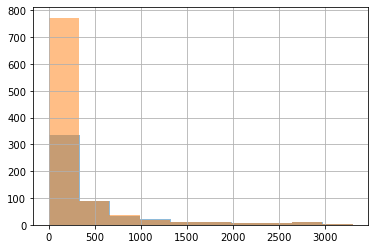

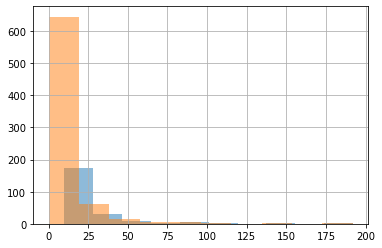

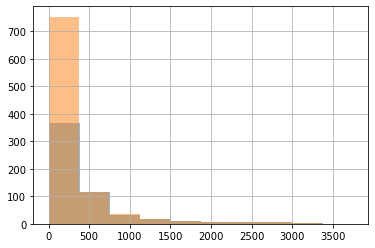

In [230]:
# comparing the distribution of data with all accounts to data only including accounts of COVID-19 deaths > 0
# this may change my question to: Of the reported COVID-19 deaths that are greater than zero, are there significant
# differnces between age groups?
df_nz_covid = df[df['COVID-19 Deaths'] >= 1]
# df_nonzero['COVID-19 Deaths'].value_counts()
df_nz_covid['COVID-19 Deaths'].hist(alpha = 0.5)
df['COVID-19 Deaths'].hist(alpha = 0.5)
plt.show()

# Here the distribution of the Influenza Deaths datasets that include 0 reported deaths
# and without including the 0 reported deaths.
df_nz_flu = df[df['Influenza Deaths'] >= 1]
df_nz_flu['Influenza Deaths'].hist(alpha = 0.5)
df['Influenza Deaths'].hist(alpha = 0.5)
plt.show()

# Here the distribution of the Pneumonia Deaths datasets that include 0 reported deaths
# and without including the 0 reported deaths.

df_nz_pneu = df[df['Pneumonia Deaths'] >= 1]
df_nz_pneu['Pneumonia Deaths'].hist(alpha = 0.5)
df['Pneumonia Deaths'].hist(alpha = 0.5)
plt.show()


In [173]:
# Here the quantity a values per 'Age group' can be observed
# These groups are too small by themselves for valuable testing,
# so they will be combined into a couple larger groups. 
df_nz_covid['Age group'].value_counts()

75-84 years          104
85 years and over    103
65-74 years          102
50-64 years           98
30-49 years           83
18-29 years           28
0-17 years             2
Name: Age group, dtype: int64

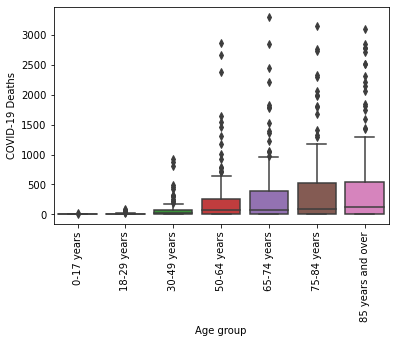

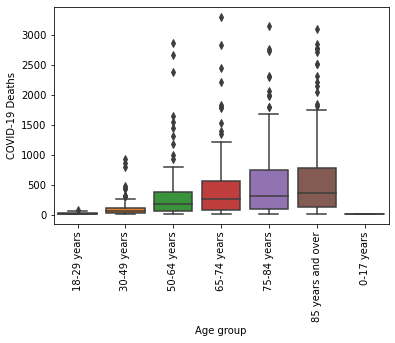

In [269]:
# observing data with '0 COVID-19 deaths reported' data included
sns.boxplot(x='Age group', y='COVID-19 Deaths', data = df)
plt.xticks(rotation='vertical')
plt.show()

# observing data with COVID-19 deaths > 0
# I think that it will be of greater value to observe instances where the virus is fatally active
sns.boxplot(x='Age group', y='COVID-19 Deaths', data = df_nz_covid)
plt.xticks(rotation='vertical')
plt.show()

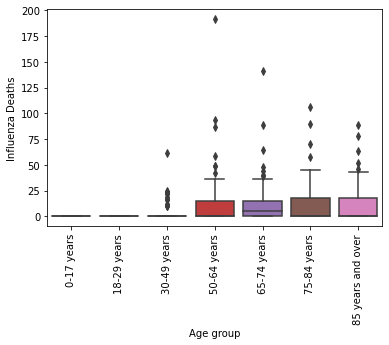

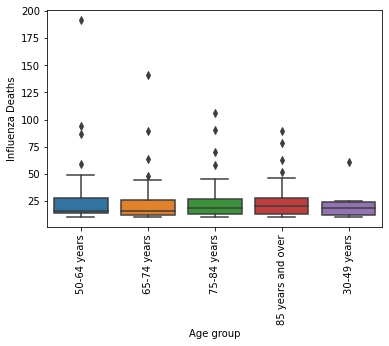

In [270]:
# observing data with '0 Influenza deaths reported' data included
sns.boxplot(x='Age group', y='Influenza Deaths', data = df)
plt.xticks(rotation='vertical')
plt.show()

# observing data with Influenza deaths > 0
# I think that it will be of greater value to observe instances where the virus is fatally active
sns.boxplot(x='Age group', y='Influenza Deaths', data = df_nz_flu)
plt.xticks(rotation='vertical')
plt.show()

It is shown that the only groups that have Influenza Deaths reported >=1 are in the 'Age groups' for 30 years and up.

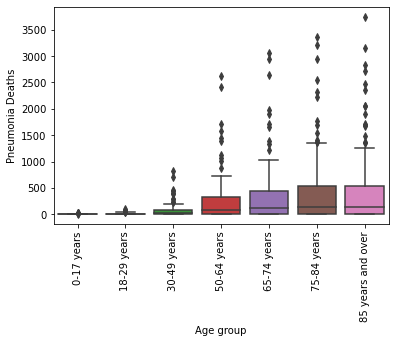

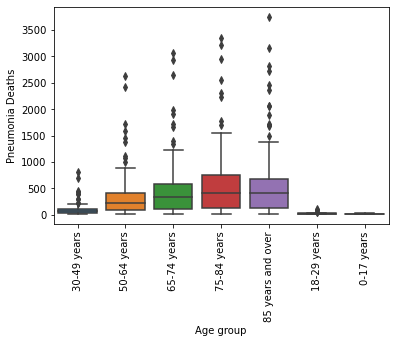

In [271]:
# observing data with '0 Pneumonia deaths reported' data included
sns.boxplot(x='Age group', y='Pneumonia Deaths', data = df)
plt.xticks(rotation='vertical')
plt.show()

# observing data with Pneumonia deaths > 0
# I think that it will be of greater value to observe instances where the virus is fatally active
sns.boxplot(x='Age group', y='Pneumonia Deaths', data = df_nz_pneu)
plt.xticks(rotation='vertical')
plt.show()

As shown on the above box plot of the Influenza deaths, the box plot of the Pneumonia deaths reported >= 1 are mostly in the 'Age groups' for 50 years and up, maybe even 30 years and up.

None of the data grouped by 'Age group' for 'COVID-19 Deaths > 0' has a normal distribution, so a normal t-test will not due.

* For the COVID-19 data in this project there are too few values for the the younger age groups so I will combine them and compare ages groups '0-49' to '50+'. It can also be compared in groups '30-49', '50-64', '65-74', '75-84', and '85+'.
* The Flu deaths data will be compared in the age groups: '30-49', '50-64', '65-74', '75-84', and '85+'.
* Pneumonia deaths data will also be compared in the same age groups: '30-49', '50-64', '65-74', '75-84', and '85+'.

In [272]:
df_nz_covid = df[df['COVID-19 Deaths'] >= 1]
df_nz_flu = df[df['Influenza Deaths'] >= 1]
df_nz_pneu = df[df['Pneumonia Deaths'] >= 1]

nolist = ['50-64 years', '65-74 years', '75-84 years', '85 years and over']
for x in nolist:
    df_nz_covid = df_nz_covid[df_nz_covid['Age group'] != x]
    df_nz_flu = df_nz_flu[df_nz_flu['Age group'] != x]
    df_nz_pneu = df_nz_pneu[df_nz_pneu['Age group'] != x]


df_0_49_covid = df_nz_covid
df_0_49_flu = df_nz_flu
df_0_49_pneu = df_nz_pneu


df_nz_flu = df[df['Influenza Deaths'] >= 1]
df_nz_covid = df[df['COVID-19 Deaths'] >= 1]
df_nz_pneu = df[df['Pneumonia Deaths'] >= 1]

nolist = ['0-17 years', '18-29 years', '30-49 years']
for x in nolist:
    df_nz_flu = df_nz_flu[df_nz_flu['Age group'] != x]
    df_nz_covid = df_nz_covid[df_nz_covid['Age group'] != x]
    df_nz_pneu = df_nz_pneu[df_nz_pneu['Age group'] != x]

df_50plus_covid = df_nz_covid
df_50plus_flu = df_nz_flu
df_50plus_pneu = df_nz_pneu

df_nz_covid = df[df['COVID-19 Deaths'] >= 1]
df_nz_flu = df[df['Influenza Deaths'] >= 1]
df_nz_pneu = df[df['Pneumonia Deaths'] >= 1]
nolist = ['0-17 years', '18-29 years', '50-64 years', '65-74 years', '75-84 years', '85 years and over']
for x in nolist:
    df_nz_covid = df_nz_covid[df_nz_covid['Age group'] != x]
    df_nz_flu = df_nz_flu[df_nz_flu['Age group'] != x]
    df_nz_pneu = df_nz_pneu[df_nz_pneu['Age group'] != x]
    
df_30_49_covid = df_nz_covid
df_30_49_flu  = df_nz_flu 
df_30_49_pneu = df_nz_pneu

df_nz_covid = df[df['COVID-19 Deaths'] >= 1]
df_nz_flu = df[df['Influenza Deaths'] >= 1]
df_nz_pneu = df[df['Pneumonia Deaths'] >= 1]
nolist = ['0-17 years', '18-29 years', '30-49 years', '65-74 years', '75-84 years', '85 years and over']
for x in nolist:
    df_nz_covid = df_nz_covid[df_nz_covid['Age group'] != x]
    df_nz_flu = df_nz_flu[df_nz_flu['Age group'] != x]
    df_nz_pneu = df_nz_pneu[df_nz_pneu['Age group'] != x]
    
df_50_64_covid = df_nz_covid
df_50_64_flu  = df_nz_flu 
df_50_64_pneu = df_nz_pneu

df_nz_covid = df[df['COVID-19 Deaths'] >= 1]
df_nz_flu = df[df['Influenza Deaths'] >= 1]
df_nz_pneu = df[df['Pneumonia Deaths'] >= 1]
nolist = ['0-17 years', '18-29 years', '30-49 years', '50-64 years', '75-84 years', '85 years and over']
for x in nolist:
    df_nz_covid = df_nz_covid[df_nz_covid['Age group'] != x]
    df_nz_flu = df_nz_flu[df_nz_flu['Age group'] != x]
    df_nz_pneu = df_nz_pneu[df_nz_pneu['Age group'] != x]
    
df_65_74_covid = df_nz_covid
df_65_74_flu  = df_nz_flu 
df_65_74_pneu = df_nz_pneu

df_nz_covid = df[df['COVID-19 Deaths'] >= 1]
df_nz_flu = df[df['Influenza Deaths'] >= 1]
df_nz_pneu = df[df['Pneumonia Deaths'] >= 1]
nolist = ['0-17 years', '18-29 years', '30-49 years', '50-64 years', '65-74 years', '85 years and over']
for x in nolist:
    df_nz_covid = df_nz_covid[df_nz_covid['Age group'] != x]
    df_nz_flu = df_nz_flu[df_nz_flu['Age group'] != x]
    df_nz_pneu = df_nz_pneu[df_nz_pneu['Age group'] != x]
    
df_75_84_covid = df_nz_covid
df_75_84_flu  = df_nz_flu 
df_75_84_pneu = df_nz_pneu

df_nz_covid = df[df['COVID-19 Deaths'] >= 1]
df_nz_flu = df[df['Influenza Deaths'] >= 1]
df_nz_pneu = df[df['Pneumonia Deaths'] >= 1]
nolist = ['0-17 years', '18-29 years', '30-49 years', '50-64 years', '65-74 years', '75-84 years']
for x in nolist:
    df_nz_covid = df_nz_covid[df_nz_covid['Age group'] != x]
    df_nz_flu = df_nz_flu[df_nz_flu['Age group'] != x]
    df_nz_pneu = df_nz_pneu[df_nz_pneu['Age group'] != x]
    
df_85plus_covid = df_nz_covid
df_85plus_flu  = df_nz_flu 
df_85plus_pneu = df_nz_pneu

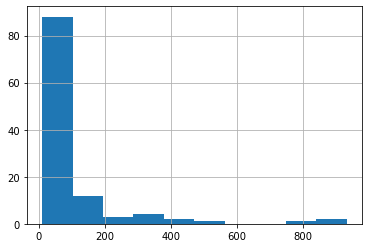

DescribeResult(nobs=113, minmax=(10.0, 932.0), mean=96.070796460177, variance=25213.31637168141, skewness=3.51510548423969, kurtosis=13.470005280022523)


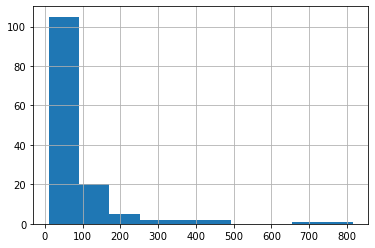

DescribeResult(nobs=138, minmax=(10.0, 816.0), mean=77.81159420289855, variance=13736.650375542156, skewness=3.776430829374161, kurtosis=17.082683667745442)


In [273]:
df_0_49_covid['COVID-19 Deaths'].hist()
plt.show()
print(stats.describe(df_0_49_covid['COVID-19 Deaths']))

df_0_49_pneu['Pneumonia Deaths'].hist()
plt.show()
print(stats.describe(df_0_49_pneu['Pneumonia Deaths']))

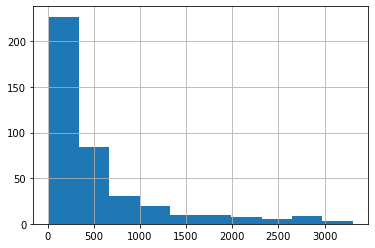

DescribeResult(nobs=407, minmax=(10.0, 3307.0), mean=524.2383292383292, variance=446490.2460149356, skewness=2.0707850354818573, kurtosis=3.9170710792020165)


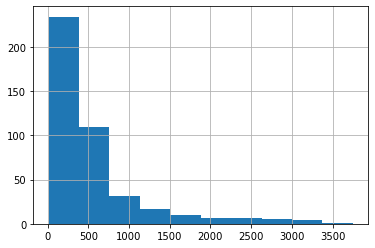

DescribeResult(nobs=423, minmax=(11.0, 3749.0), mean=521.0472813238771, variance=394844.5759582311, skewness=2.3803714293192875, kurtosis=6.217684601992035)


In [275]:
df_50plus_covid['COVID-19 Deaths'].hist()
plt.show()
print(stats.describe(df_50plus_covid['COVID-19 Deaths']))

df_50plus_pneu['Pneumonia Deaths'].hist()
plt.show()
print(stats.describe(df_50plus_pneu['Pneumonia Deaths']))

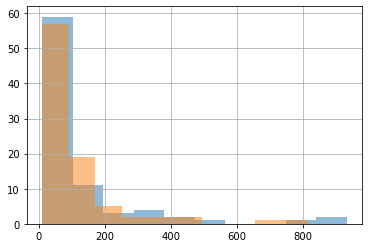

DescribeResult(nobs=83, minmax=(11.0, 932.0), mean=121.3132530120482, variance=31873.168968557155, skewness=2.9800821997393245, kurtosis=9.293286259503768)
DescribeResult(nobs=89, minmax=(10.0, 816.0), mean=107.95505617977528, variance=18605.202502553624, skewness=3.1045478290130935, kurtosis=11.032803465746886)


In [235]:
df_30_49_covid['COVID-19 Deaths'].hist(alpha = 0.5)
#df_30_49_flu['Influenza Deaths'].hist(alpha = 0.5)
df_30_49_pneu['Pneumonia Deaths'].hist(alpha = 0.5)
plt.show()

print(stats.describe(df_30_49_covid['COVID-19 Deaths']))
print(stats.describe(df_30_49_pneu['Pneumonia Deaths']))


DescribeResult(nobs=98, minmax=(10.0, 2870.0), mean=362.11224489795916, variance=284550.49242583633, skewness=2.8853916270148234, kurtosis=8.93426180670869)
DescribeResult(nobs=55, minmax=(10.0, 192.0), mean=25.98181818181818, variance=808.3144781144779, skewness=4.165228883516118, kurtosis=20.024052027953868)
DescribeResult(nobs=105, minmax=(12.0, 2617.0), mean=357.1047619047619, variance=207509.19084249085, skewness=2.7849454770133923, kurtosis=9.016065015921544)


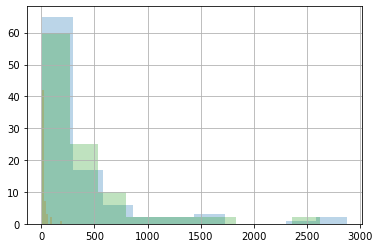

In [195]:
df_50_64_covid['COVID-19 Deaths'].hist(alpha = 0.3)
df_50_64_flu['Influenza Deaths'].hist(alpha = 0.3)
df_50_64_pneu['Pneumonia Deaths'].hist(alpha = 0.3)

print(stats.describe(df_50_64_covid['COVID-19 Deaths']))
print(stats.describe(df_50_64_flu['Influenza Deaths']))
print(stats.describe(df_50_64_pneu ['Pneumonia Deaths']))


DescribeResult(nobs=102, minmax=(10.0, 3307.0), mean=475.8529411764706, variance=382171.17617938254, skewness=2.3898339424425545, kurtosis=6.146198198962882)
DescribeResult(nobs=54, minmax=(10.0, 141.0), mean=23.48148148148148, variance=481.235499650594, skewness=3.549186498808678, kurtosis=14.684512191008029)
DescribeResult(nobs=106, minmax=(11.0, 3066.0), mean=488.39622641509436, variance=340375.04150943394, skewness=2.4606313288563415, kurtosis=6.768895223860815)


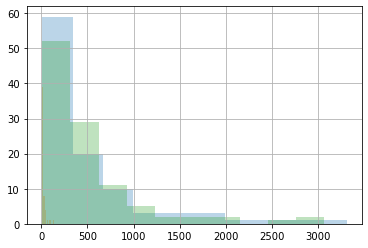

In [199]:
df_65_74_covid['COVID-19 Deaths'].hist(alpha = 0.3)
df_65_74_flu['Influenza Deaths'].hist(alpha = 0.3)
df_65_74_pneu['Pneumonia Deaths'].hist(alpha = 0.3)

print(stats.describe(df_65_74_covid['COVID-19 Deaths']))
print(stats.describe(df_65_74_flu['Influenza Deaths']))
print(stats.describe(df_65_74_pneu ['Pneumonia Deaths']))


DescribeResult(nobs=104, minmax=(12.0, 3155.0), mean=576.5, variance=462481.0291262136, skewness=1.829312401675514, kurtosis=2.9528695976206825)
DescribeResult(nobs=54, minmax=(10.0, 106.0), mean=24.37037037037037, variance=370.765897973445, skewness=2.523546703311763, kurtosis=6.734601161073385)
DescribeResult(nobs=106, minmax=(15.0, 3354.0), mean=600.0849056603773, variance=459683.5451033243, skewness=2.143577784197861, kurtosis=4.86317342735765)


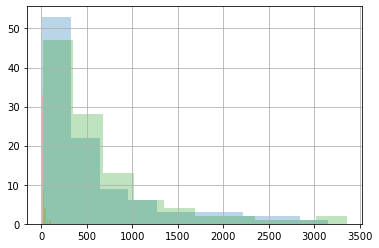

In [197]:
df_75_84_covid['COVID-19 Deaths'].hist(alpha = 0.3)
df_75_84_flu['Influenza Deaths'].hist(alpha = 0.3)
df_75_84_pneu['Pneumonia Deaths'].hist(alpha = 0.3)

print(stats.describe(df_75_84_covid['COVID-19 Deaths']))
print(stats.describe(df_75_84_flu['Influenza Deaths']))
print(stats.describe(df_75_84_pneu ['Pneumonia Deaths']))


DescribeResult(nobs=103, minmax=(12.0, 3099.0), mean=673.6407766990292, variance=608244.7814582144, skewness=1.5858092389978162, kurtosis=1.5102057557491637)
DescribeResult(nobs=49, minmax=(10.0, 89.0), mean=24.26530612244898, variance=287.65731292517006, skewness=2.130862368093722, kurtosis=4.606706810245419)
DescribeResult(nobs=106, minmax=(16.0, 3749.0), mean=637.0566037735849, variance=533461.4824797844, skewness=2.068607333119829, kurtosis=4.243858521146309)


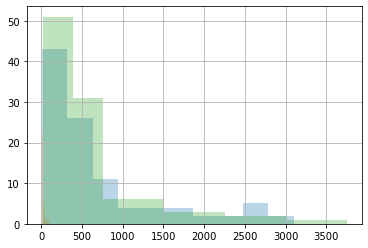

In [198]:
df_85plus_covid['COVID-19 Deaths'].hist(alpha = 0.3)
df_85plus_flu['Influenza Deaths'].hist(alpha = 0.3)
df_85plus_pneu['Pneumonia Deaths'].hist(alpha = 0.3)

print(stats.describe(df_85plus_covid['COVID-19 Deaths']))
print(stats.describe(df_85plus_flu['Influenza Deaths']))
print(stats.describe(df_85plus_pneu ['Pneumonia Deaths']))

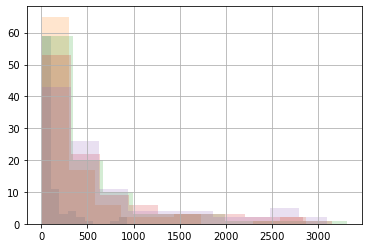

In [202]:
df_30_49_covid['COVID-19 Deaths'].hist(alpha = 0.2)
df_50_64_covid['COVID-19 Deaths'].hist(alpha = 0.2)
df_65_74_covid['COVID-19 Deaths'].hist(alpha = 0.2)
df_75_84_covid['COVID-19 Deaths'].hist(alpha = 0.2)
df_85plus_covid['COVID-19 Deaths'].hist(alpha = 0.2)
plt.show()


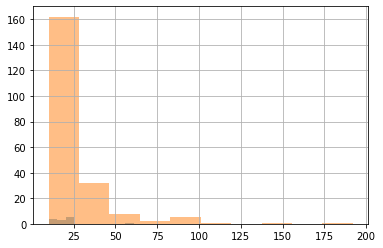

In [204]:
df_0_49_flu['Influenza Deaths'].hist(alpha = 0.5)
df_50plus_flu['Influenza Deaths'].hist(alpha = 0.5)
plt.show()

This shows that there isn't enough data in the '0-49' age group for Influenza deaths for an accurate analysis.
Value counts of the columns confirms this.

In [205]:
df_0_49_flu['Influenza Deaths'].value_counts()

10.0    2
24.0    2
16.0    1
11.0    1
17.0    1
12.0    1
23.0    1
61.0    1
19.0    1
22.0    1
25.0    1
Name: Influenza Deaths, dtype: int64

In [206]:
df_50plus_flu['Influenza Deaths'].value_counts()

13.0     25
12.0     22
15.0     17
19.0     11
14.0     11
11.0     11
10.0     10
16.0      8
20.0      7
17.0      6
22.0      6
18.0      6
23.0      5
34.0      5
27.0      4
29.0      4
21.0      4
32.0      3
28.0      3
24.0      3
36.0      3
39.0      3
30.0      3
26.0      2
49.0      2
45.0      2
89.0      2
87.0      1
58.0      1
64.0      1
94.0      1
90.0      1
59.0      1
31.0      1
25.0      1
43.0      1
52.0      1
63.0      1
48.0      1
70.0      1
42.0      1
40.0      1
41.0      1
78.0      1
37.0      1
106.0     1
35.0      1
141.0     1
192.0     1
46.0      1
44.0      1
Name: Influenza Deaths, dtype: int64

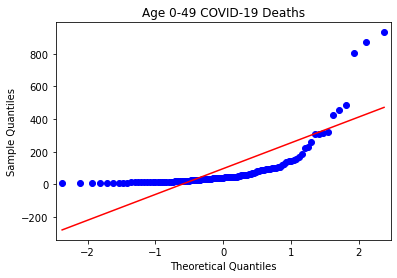

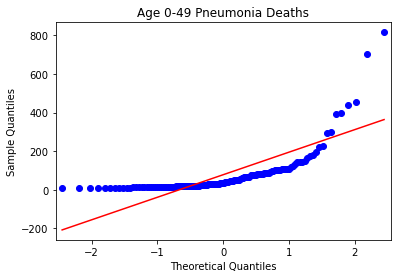

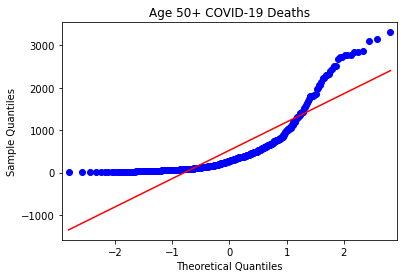

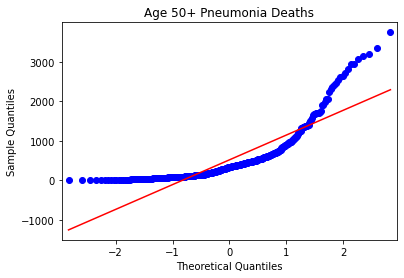

In [276]:
qqplot(df_0_49_covid['COVID-19 Deaths'], line = 's')
plt.title("Age 0-49 COVID-19 Deaths")
plt.show()

qqplot(df_0_49_pneu['Pneumonia Deaths'], line = 's')
plt.title("Age 0-49 Pneumonia Deaths")
plt.show()

qqplot(df_50plus_covid['COVID-19 Deaths'], line = 's')
plt.title('Age 50+ COVID-19 Deaths')
plt.show()

qqplot(df_50plus_pneu['Pneumonia Deaths'], line = 's')
plt.title('Age 50+ Pneumonia Deaths')
plt.show()

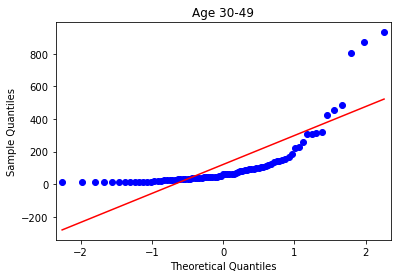

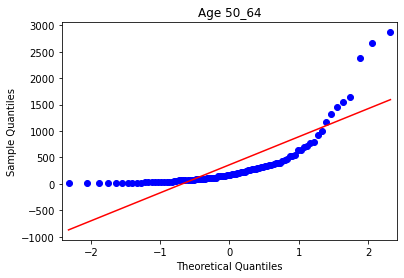

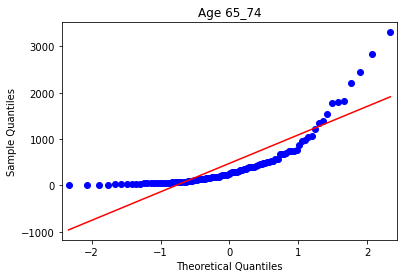

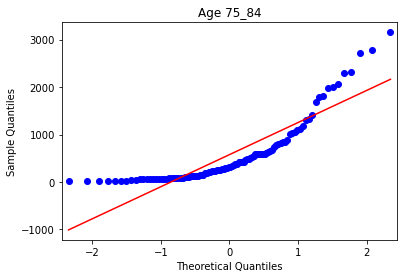

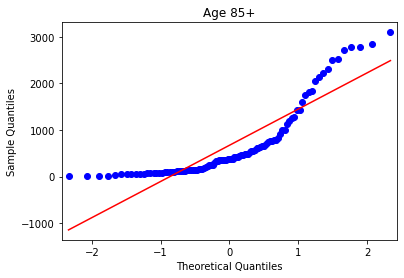

In [208]:
qqplot(df_30_49_covid['COVID-19 Deaths'], line = 's')
plt.title("Age 30-49")
plt.show()

qqplot(df_50_64_covid['COVID-19 Deaths'], line = 's')
plt.title('Age 50_64')
plt.show()

qqplot(df_65_74_covid['COVID-19 Deaths'], line = 's')
plt.title('Age 65_74')
plt.show()

qqplot(df_75_84_covid['COVID-19 Deaths'], line = 's')
plt.title('Age 75_84')
plt.show()

qqplot(df_85plus_covid['COVID-19 Deaths'], line = 's')
plt.title('Age 85+')
plt.show()

* As seen via the qqplot, the two data sets('0-49', '50+') are not normally distributed, but the do have a similar distribution.
* For the age groups('30-49', '50-64', '65-74', '75-84', and '85+') the distributions are not normal, but they can be observed to be similar.

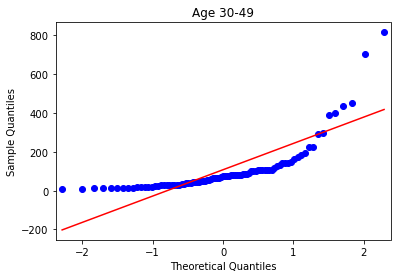

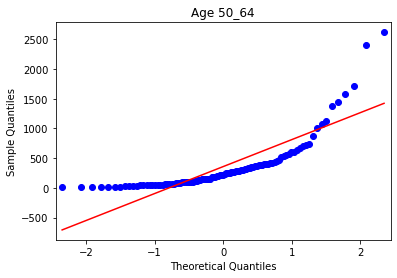

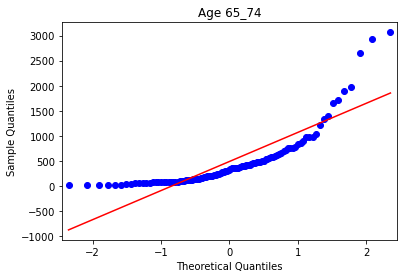

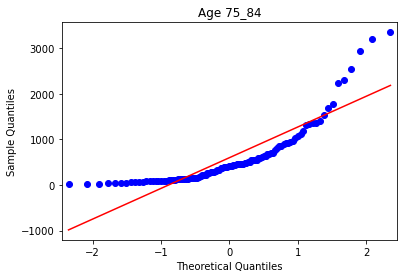

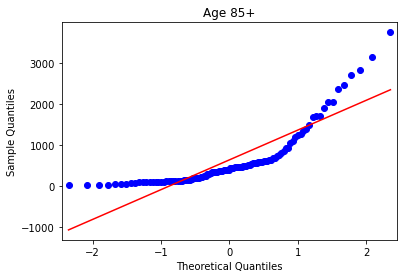

In [236]:
qqplot(df_30_49_pneu['Pneumonia Deaths'], line = 's')
plt.title("Age 30-49")
plt.show()

qqplot(df_50_64_pneu['Pneumonia Deaths'], line = 's')
plt.title('Age 50_64')
plt.show()

qqplot(df_65_74_pneu['Pneumonia Deaths'], line = 's')
plt.title('Age 65_74')
plt.show()

qqplot(df_75_84_pneu['Pneumonia Deaths'], line = 's')
plt.title('Age 75_84')
plt.show()

qqplot(df_85plus_pneu['Pneumonia Deaths'], line = 's')
plt.title('Age 85+')
plt.show()

* For the age groups('30-49', '50-64', '65-74', '75-84', and '85+') the distributions are not normal, but they can be observed to be similar.

In [279]:
_, p_covid = stats.kruskal(df_0_49_covid['COVID-19 Deaths'], df_50plus_covid['COVID-19 Deaths'])

_, p_pneu = stats.kruskal(df_0_49_pneu['Pneumonia Deaths'], df_50plus_pneu['Pneumonia Deaths'])

p, p_pneu

(2.576791968018485e-16, 3.107739462972778e-39)

In [281]:
p < 0.05, p_pneu < 0.05

(True, True)

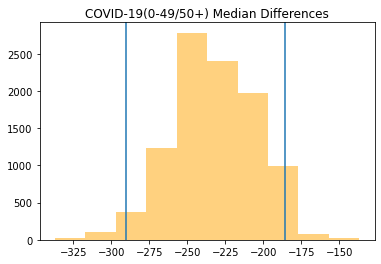

(-290.0, -186.0)

In [287]:
median_diffs = []
for i in range(10000):
    sample_1 = df_0_49_covid['COVID-19 Deaths'].sample(frac=1.0, replace=True)
    sample_2 = df_50plus_covid['COVID-19 Deaths'].sample(frac=1.0, replace=True)

    median_diff = sample_1.median() - sample_2.median()
    median_diffs.append(median_diff)

ci_lo = np.percentile(median_diffs, 2.5)
ci_hi = np.percentile(median_diffs, 97.5)

plt.hist(median_diffs, color = 'orange', alpha = 0.5)
plt.title('COVID-19(0-49/50+) Median Differences')
plt.axvline(ci_lo)
plt.axvline(ci_hi)
plt.show()

ci_lo, ci_hi

* COVID-19: We can see from the analysis above that when considering only non-zero death counts, there are 186 to 293 more deaths reported in the '50+' age group compared to the '0-49' age group.

In [297]:
print(calc_non_param_ci(df_0_49_covid['COVID-19 Deaths'], df_50plus_covid['COVID-19 Deaths'], alpha=0.05))
print(cles_ind(df_0_49_covid['COVID-19 Deaths'], df_50plus_covid['COVID-19 Deaths']))

(-264.0, -134.0)
0.8228783892500706


* COVID-19: According to the calc_non_param_ci() function there are likely to be 134 to 264 more deaths in the '50+' group than the '0-49' group. This estimation comes up similar to the bootstrap calculation done before it. According to the common language effect size, the number of COVID-19 deaths reported from the '50+' age group would be expected to be ~82.3% larger than the COVID-19 deaths reported from the '0-49' age group when we only consider deaths reported to be >= 1.

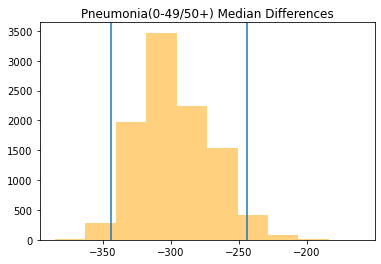

(-344.0, -244.0)

In [286]:
median_diffs = []
for i in range(10000):
    sample_1 = df_0_49_pneu['Pneumonia Deaths'].sample(frac=1.0, replace=True)
    sample_2 = df_50plus_pneu['Pneumonia Deaths'].sample(frac=1.0, replace=True)

    median_diff = sample_1.median() - sample_2.median()
    median_diffs.append(median_diff)

ci_lo = np.percentile(median_diffs, 2.5)
ci_hi = np.percentile(median_diffs, 97.5)

plt.hist(median_diffs, color = 'orange', alpha = 0.5)
plt.title('Pneumonia(0-49/50+) Median Differences')
plt.axvline(ci_lo)
plt.axvline(ci_hi)
plt.show()

ci_lo, ci_hi

* Pneumonia: We can see from the analysis above that when considering only non-zero death counts, there are 244 to 344 more deaths reported in the '50+' age group compared to the '0-49' age group.

In [296]:
print(calc_non_param_ci(df_0_49_pneu['Pneumonia Deaths'], df_50plus_pneu['Pneumonia Deaths'], alpha=0.05))
print(cles_ind(df_0_49_pneu['Pneumonia Deaths'], df_50plus_pneu['Pneumonia Deaths']))

(-319.0, -196.0)
0.8699078356802686


* Pneumonia: According to the calc_non_param_ci() function there are likely to be 196 to 319 more deaths in the '50+' group than the '0-49' group. This estimation comes up similar to the bootstrap calculation done before it. According to the common language effect size, the number of Pneumonia deaths reported from the '50+' age group would be expected to be ~87% larger than the Pneumonia deaths reported from the '0-49' age group when we only consider deaths reported to be >= 1.

In [241]:
_, p = stats.kruskal(df_30_49_covid['COVID-19 Deaths'], df_50_64_covid['COVID-19 Deaths'], df_65_74_covid['COVID-19 Deaths'], df_75_84_covid['COVID-19 Deaths'], df_85plus_covid['COVID-19 Deaths'])
p

2.576791968018485e-16

In [242]:
p < 0.05

True

* This shows that in the data for COVID-19 deaths, amongst the smaller age groups ('30-49', '50-64', etc...), there are statistically significant differences.


In [244]:
_, p_pneu = stats.kruskal(df_30_49_pneu['Pneumonia Deaths'], df_50_64_pneu['Pneumonia Deaths'], df_65_74_pneu['Pneumonia Deaths'], df_75_84_pneu['Pneumonia Deaths'], df_85plus_pneu['Pneumonia Deaths'])
p_pneu

7.345934200440035e-22

In [245]:
p_pneu < 0.05

True

* This shows that in the data for Pneumonia deaths, amongst the smaller age groups('30-49', '50-64', etc...), there are statistically significant differences.

By performing a Kruskal-Wallis test on all the different combinations and accounting for the increased risk of a 'type: I error' from multiple testing by using the multipletests() function, the groups that are significantly different can be identified.

In [250]:
_, p_3049_5064 = stats.kruskal(df_30_49_covid["COVID-19 Deaths"], df_50_64_covid["COVID-19 Deaths"])
_, p_3049_6574 = stats.kruskal(df_30_49_covid["COVID-19 Deaths"], df_65_74_covid["COVID-19 Deaths"])
_, p_3049_7584 = stats.kruskal(df_30_49_covid["COVID-19 Deaths"], df_75_84_covid["COVID-19 Deaths"])
_, p_3049_85plus = stats.kruskal(df_30_49_covid["COVID-19 Deaths"], df_85plus_covid["COVID-19 Deaths"])
_, p_5064_6574 = stats.kruskal(df_50_64_covid["COVID-19 Deaths"], df_65_74_covid["COVID-19 Deaths"])
_, p_5064_7584 = stats.kruskal(df_50_64_covid["COVID-19 Deaths"], df_75_84_covid["COVID-19 Deaths"])
_, p_5064_85plus = stats.kruskal(df_50_64_covid["COVID-19 Deaths"], df_85plus_covid["COVID-19 Deaths"])
_, p_6574_7584 = stats.kruskal(df_65_74_covid["COVID-19 Deaths"], df_75_84_covid["COVID-19 Deaths"])
_, p_6574_85plus = stats.kruskal(df_65_74_covid["COVID-19 Deaths"], df_85plus_covid["COVID-19 Deaths"])
_, p_7584_85plus = stats.kruskal(df_75_84_covid["COVID-19 Deaths"], df_85plus_covid["COVID-19 Deaths"])


In [251]:
print(p_3049_5064)
print(p_3049_5064 < 0.05)
print(p_3049_5064)
print(p_3049_5064 < 0.05)
print(p_3049_7584)
print(p_3049_7584 < 0.05)
print(p_3049_85plus)
print(p_3049_85plus < 0.05)
print(p_5064_7584)
print(p_5064_7584 < 0.05)
print(p_5064_85plus)
print(p_5064_85plus < 0.05)

5.175488899232059e-07
True
5.175488899232059e-07
True
1.6222467388262523e-12
True
6.378887162387466e-15
True
0.0047638841071166735
True
0.00022754985933204689
True


In [252]:
_, ppn_3049_5064 = stats.kruskal(df_30_49_pneu["Pneumonia Deaths"], df_50_64_pneu["Pneumonia Deaths"])
_, ppn_3049_6574 = stats.kruskal(df_30_49_pneu["Pneumonia Deaths"], df_65_74_pneu["Pneumonia Deaths"])
_, ppn_3049_7584 = stats.kruskal(df_30_49_pneu["Pneumonia Deaths"], df_75_84_pneu["Pneumonia Deaths"])
_, ppn_3049_85plus = stats.kruskal(df_30_49_pneu["Pneumonia Deaths"], df_85plus_pneu["Pneumonia Deaths"])
_, ppn_5064_6574 = stats.kruskal(df_50_64_pneu["Pneumonia Deaths"], df_65_74_pneu["Pneumonia Deaths"])
_, ppn_5064_7584 = stats.kruskal(df_50_64_pneu["Pneumonia Deaths"], df_75_84_pneu["Pneumonia Deaths"])
_, ppn_5064_85plus = stats.kruskal(df_50_64_pneu["Pneumonia Deaths"], df_85plus_pneu["Pneumonia Deaths"])
_, ppn_6574_7584 = stats.kruskal(df_65_74_pneu["Pneumonia Deaths"], df_75_84_pneu["Pneumonia Deaths"])
_, ppn_6574_85plus = stats.kruskal(df_65_74_pneu["Pneumonia Deaths"], df_85plus_pneu["Pneumonia Deaths"])
_, ppn_7584_85plus = stats.kruskal(df_75_84_pneu["Pneumonia Deaths"], df_85plus_pneu["Pneumonia Deaths"])

In [253]:
print(ppn_3049_5064)
print(ppn_3049_5064 < 0.05)
print(ppn_3049_5064)
print(ppn_3049_5064 < 0.05)
print(ppn_3049_7584)
print(ppn_3049_7584 < 0.05)
print(ppn_3049_85plus)
print(ppn_3049_85plus < 0.05)
print(ppn_5064_7584)
print(ppn_5064_7584 < 0.05)
print(ppn_5064_85plus)
print(ppn_5064_85plus < 0.05)

3.114617853158678e-09
True
3.114617853158678e-09
True
6.082058333208616e-17
True
1.0844983551129301e-18
True
0.0006083506737812142
True
0.00019058691406296198
True


In [254]:
reject_h0, _, _, _ = multipletests([p_3049_5064, p_3049_6574, p_3049_7584, p_3049_85plus, p_5064_6574, p_5064_7584, p_5064_85plus, p_6574_7584, p_6574_85plus, p_7584_85plus])
reject_h0

array([ True,  True,  True,  True, False,  True,  True, False, False,
       False])

In [255]:
reject_h0, _, _, _ = multipletests([ppn_3049_5064, ppn_3049_6574, ppn_3049_7584, ppn_3049_85plus, ppn_5064_6574, ppn_5064_7584, ppn_5064_85plus, ppn_6574_7584, ppn_6574_85plus, ppn_7584_85plus])
reject_h0

array([ True,  True,  True,  True, False,  True,  True, False, False,
       False])

Running the multipletests() function shows that significant differences exist between the following groups:
* COVID-19: ('30-49': all other ages), and ('50-64': '75-84', '85+')
* Pneumonia: ('30-49': all other ages), and ('50-64': '75-84', '85+')

This comparison shows that COVID-19 and Pneumonia have a similar impact on the different ages groups.

* The correction for multiple test shows that youngest group (30-49) has a significant difference when compared to the other age groups.
* The other age groups only show a significant difference when compared to groups that have greater then 10 or more years difference.


In [295]:
print(calc_non_param_ci(df_30_49_covid['COVID-19 Deaths'], df_50_64_covid['COVID-19 Deaths'], alpha=0.05))
print(calc_non_param_ci(df_30_49_pneu['Pneumonia Deaths'], df_50_64_pneu['Pneumonia Deaths'], alpha=0.05))
print(cles_ind(df_30_49_covid['COVID-19 Deaths'],df_50_64_covid['COVID-19 Deaths']))
print(cles_ind(df_30_49_pneu['Pneumonia Deaths'],df_50_64_pneu['Pneumonia Deaths']))

(-145.0, -48.0)
(-194.0, -73.0)
0.7147774772559626
0.7457463884430177


* COVID-19: This CI calculation states that the '50-64' age group will have 48-145 more deaths reported than the '30-49' age group. The common language effect size for the '30-49' to '50-64' age groups COVID-19 deaths comparison states that the '50-64' age group should have 71.5% more deaths than the '30-49' age group when only considering reportings >= 1.
* Pneumonia: This CI calculation states that the '50-64' age group will have 73-194 more deaths reported than the '30-49' age group. The common language effect size for the '30-49' to '50-64' age groups Pneumonia deaths comparison states that the '50-64' age group should have 74.6% more deaths than the '30-49' age group when only considering reportings >= 1.

In [294]:
print(calc_non_param_ci(df_30_49_covid['COVID-19 Deaths'], df_65_74_covid['COVID-19 Deaths'], alpha=0.05))
print(calc_non_param_ci(df_30_49_pneu['Pneumonia Deaths'], df_65_74_pneu['Pneumonia Deaths'], alpha=0.05))
print(cles_ind(df_30_49_covid['COVID-19 Deaths'],df_65_74_covid['COVID-19 Deaths']))
print(cles_ind(df_30_49_pneu['Pneumonia Deaths'],df_65_74_pneu['Pneumonia Deaths']))

(-250.0, -92.0)
(-309.0, -133.0)
0.767776990314198
0.8077167691329235


* COVID-19: This calculated CI shows that the '65-74' age group can expect 92-250 more COVID-19 deaths than the '30-49' age group.The common language effect size for this comparison, ('30-49' : '65-74'), states the older age group would expect 76.7% more COVID-19 deaths than the younger group.
* Pneumonia: This calculated CI shows that the '65-74' age group can expect 133-309 more Pneumonia deaths than the '30-49' age group.The common language effect size for this comparison, ('30-49' : '65-74'), states the older age group would expect 80.8% more Pneumonia deaths than the younger group.

In [293]:
print(calc_non_param_ci(df_30_49_covid['COVID-19 Deaths'], df_75_84_covid['COVID-19 Deaths'], alpha=0.05))
print(calc_non_param_ci(df_30_49_pneu['Pneumonia Deaths'], df_75_84_pneu['Pneumonia Deaths'], alpha=0.05))
print(cles_ind(df_30_49_covid['COVID-19 Deaths'],df_75_84_covid['COVID-19 Deaths']))
print(cles_ind(df_30_49_pneu['Pneumonia Deaths'],df_75_84_pneu['Pneumonia Deaths']))

(-338.0, -130.0)
(-395.0, -203.0)
0.8000463392029658
0.8471486114055544


* COVID-19: This CI calculation states that the '75-84' age group will have 130-338 more deaths reported than the '30-49' age group, or according to the CLES, there should be about 80% more COVID-19 deaths in '75-84' age group.
* Pneumonia: This CI calculation states that the '75-84' age group will have 203-395 more deaths reported than the '30-49' age group, or according to the CLES, there should be about 84.7% more COVID-19 deaths in '75-84' age group.

In [292]:
print(calc_non_param_ci(df_30_49_covid['COVID-19 Deaths'], df_85plus_covid['COVID-19 Deaths'], alpha=0.05))
print(calc_non_param_ci(df_30_49_pneu['Pneumonia Deaths'], df_85plus_pneu['Pneumonia Deaths'], alpha=0.05))
print(cles_ind(df_30_49_covid['COVID-19 Deaths'],df_85plus_covid['COVID-19 Deaths']))
print(cles_ind(df_30_49_pneu['Pneumonia Deaths'],df_85plus_pneu['Pneumonia Deaths']))

(-387.0, -163.0)
(-400.0, -223.0)
0.8321441104222717
0.866122535509858


* COVID-19: This CI calculation states that the '85+' age group will have 163-387 more deaths reported than the '30-49' age group, or according to the CLES, there should be about 83.2% more COVID-19 deaths in the '85+' age group.
* Pneumonia: This CI calculation states that the '85+' age group will have 223-400 more deaths reported than the '30-49' age group, or according to the CLES, there should be about 86.6% more Pneumonia deaths in the '85+' age group.

In [291]:
print(calc_non_param_ci(df_50_64_covid['COVID-19 Deaths'], df_75_84_covid['COVID-19 Deaths'], alpha=0.05))
print(calc_non_param_ci(df_50_64_pneu['Pneumonia Deaths'], df_75_84_pneu['Pneumonia Deaths'], alpha=0.05))
print(cles_ind(df_50_64_covid['COVID-19 Deaths'],df_75_84_covid['COVID-19 Deaths']))
print(cles_ind(df_50_64_pneu['Pneumonia Deaths'],df_75_84_pneu['Pneumonia Deaths']))

(-199.0, -27.0)
(-233.0, -47.0)
0.6142072213500785
0.635759209344115


* COVID-19: This CI calculation states that the '75-84' age group will have 27-199 more deaths reported than the '50-64' age group, or according to the CLES, there should be about 61.4% more COVID-19 deaths in the '75-84' age group.
* Pneumonia: This CI calculation states that the '75-84' age group will have 47-233 more deaths reported than the '50-64' age group, or according to the CLES, there should be about 63.6% more Pneumonia deaths in the '75-84' age group.

In [290]:
print(calc_non_param_ci(df_50_64_covid['COVID-19 Deaths'], df_85plus_covid['COVID-19 Deaths'], alpha=0.05))
print(calc_non_param_ci(df_50_64_pneu['Pneumonia Deaths'], df_85plus_pneu['Pneumonia Deaths'], alpha=0.05))
print(cles_ind(df_50_64_covid['COVID-19 Deaths'],df_85plus_covid['COVID-19 Deaths']))
print(cles_ind(df_50_64_pneu['Pneumonia Deaths'],df_85plus_pneu['Pneumonia Deaths']))

(-262.0, -54.0)
(-242.0, -62.0)
0.6497919556171984
0.6480682839173405


* COVID-19: This CI calculation states that the '85+' age group will have 54-262 more deaths reported than the '50-64' age group, and according to the CLES, there should be about 65% more in the '85+' age group.
* Pneumonia: This CI calculation states that the '85+' age group will have 62-242 more deaths reported than the '50-64' age group, and according to the CLES, there should be about 64.8% more in the '85+' age group.

The table below summarizes the findings of this analysis. The age group combinations that have statistically significant differences are listed along with their corresponding confidence intervals and common language effect sizes. It can be seen in the table that COVID-19 impacts different age groups to a greater or lesser extent, and it can be seen that COVID-19 follows a trend that is similar to how Pneumonia effects different age groups. 

Age group combo  |  COVID-19       |    Pneumonia
-----------------|-----------------|-----------------
 (30-49 : 50-64) | (48-145, 71.5%) | (73-194, 74.6%)
 (30-49 : 65-74) |(192-250, 76.7%) |(133-309, 80.8%)
 (30-49 : 75-84) |(130-338, 80.0%) |(203-395, 84.7%)
 (30-49 :  85+ ) |(163-387, 83.2%) |(223-400, 86.6%)
 (50-64 : 75-84) | (27-199, 61.4%) | (47-233, 63.6%)
 (50-64 :  85+ ) | (54-262, 65.0%) | (62-242, 64.8%)
 ( 0-49 :  50+ ) |(134-264, 82.3%) |(196-319, 87.0%)
 
                         * All other age group combinations have no statistically significant differences.
 


